Plot blocks per hour after Granada upgrade

In [1]:
import requests
import json
import datetime

print('start')

block_timestamp = {}
level = 1589000

while True:
    # Get upgrade block start height and datetime and end block height, timedate
    block_json = requests.get("https://api.tzstats.com/explorer/block/%s" % level)
    block = block_json.json()
    block_timestamp[level]=block["time"]
    print(block["time"])
    level += 1

print('end part 1')

start
2021-08-06T05:21:34Z
2021-08-06T05:22:34Z
2021-08-06T05:23:34Z
2021-08-06T05:24:34Z
2021-08-06T05:25:34Z
2021-08-06T05:26:34Z
2021-08-06T05:27:34Z
2021-08-06T05:28:34Z
2021-08-06T05:29:34Z
2021-08-06T05:30:34Z
2021-08-06T05:31:34Z
2021-08-06T05:32:34Z
2021-08-06T05:33:34Z
2021-08-06T05:34:34Z
2021-08-06T05:35:34Z
2021-08-06T05:36:34Z
2021-08-06T05:37:34Z
2021-08-06T05:38:34Z
2021-08-06T05:39:34Z
2021-08-06T05:40:34Z
2021-08-06T05:41:34Z
2021-08-06T05:42:34Z
2021-08-06T05:43:34Z
2021-08-06T05:44:34Z
2021-08-06T05:45:34Z
2021-08-06T05:46:34Z
2021-08-06T05:47:34Z
2021-08-06T05:48:34Z
2021-08-06T05:49:34Z
2021-08-06T05:50:34Z
2021-08-06T05:51:34Z
2021-08-06T05:52:34Z
2021-08-06T05:53:34Z
2021-08-06T05:54:34Z
2021-08-06T05:55:34Z
2021-08-06T05:56:34Z
2021-08-06T05:57:34Z
2021-08-06T05:58:34Z
2021-08-06T05:59:34Z
2021-08-06T06:00:34Z
2021-08-06T06:01:34Z
2021-08-06T06:02:34Z
2021-08-06T06:03:34Z
2021-08-06T06:04:34Z
2021-08-06T06:05:34Z
2021-08-06T06:06:34Z
2021-08-06T06:07:34Z
2021-08

2021-08-06T11:39:26Z
2021-08-06T11:53:14Z
2021-08-06T11:53:44Z
2021-08-06T11:58:48Z
2021-08-06T11:59:18Z
2021-08-06T12:08:06Z
2021-08-06T12:08:36Z
2021-08-06T12:09:06Z
2021-08-06T12:22:54Z
2021-08-06T12:24:34Z
2021-08-06T12:25:04Z
2021-08-06T12:27:24Z
2021-08-06T12:27:54Z
2021-08-06T12:36:30Z
2021-08-06T12:40:18Z
2021-08-06T12:40:48Z
2021-08-06T12:55:16Z
2021-08-06T12:55:46Z
2021-08-06T12:59:46Z
2021-08-06T13:00:16Z
2021-08-06T13:00:46Z
2021-08-06T13:06:46Z
2021-08-06T13:08:26Z
2021-08-06T13:08:56Z
2021-08-06T13:10:36Z
2021-08-06T13:11:06Z
2021-08-06T13:12:50Z
2021-08-06T13:14:30Z
2021-08-06T13:16:10Z
2021-08-06T13:17:50Z
2021-08-06T13:18:20Z
2021-08-06T13:18:50Z
2021-08-06T13:33:18Z
2021-08-06T13:40:26Z
2021-08-06T13:45:14Z
2021-08-06T13:45:44Z
2021-08-06T13:57:20Z
2021-08-06T13:57:50Z
2021-08-06T14:11:38Z
2021-08-06T14:12:08Z
2021-08-06T14:25:48Z
2021-08-06T14:27:28Z
2021-08-06T14:27:58Z
2021-08-06T14:28:28Z
2021-08-06T14:28:58Z
2021-08-06T14:40:30Z
2021-08-06T14:41:00Z
2021-08-06T14

2021-08-07T04:47:34Z
2021-08-07T04:48:04Z
2021-08-07T04:53:08Z
2021-08-07T04:53:38Z
2021-08-07T04:56:46Z
2021-08-07T04:58:50Z
2021-08-07T05:01:42Z
2021-08-07T05:02:12Z
2021-08-07T05:05:20Z
2021-08-07T05:10:40Z
2021-08-07T05:11:10Z
2021-08-07T05:14:50Z
2021-08-07T05:15:20Z
2021-08-07T05:18:04Z
2021-08-07T05:19:44Z
2021-08-07T05:26:44Z
2021-08-07T05:29:32Z
2021-08-07T05:33:12Z
2021-08-07T05:40:20Z
2021-08-07T05:40:50Z
2021-08-07T05:44:26Z
2021-08-07T05:51:38Z
2021-08-07T05:52:08Z
2021-08-07T05:58:24Z
2021-08-07T05:58:54Z
2021-08-07T06:03:26Z
2021-08-07T06:06:02Z
2021-08-07T06:06:32Z
2021-08-07T06:10:04Z
2021-08-07T06:14:00Z
2021-08-07T06:14:30Z
2021-08-07T06:15:00Z
2021-08-07T06:19:52Z
2021-08-07T06:21:40Z
2021-08-07T06:25:48Z
2021-08-07T06:26:18Z
2021-08-07T06:30:30Z
2021-08-07T06:31:00Z
2021-08-07T06:34:40Z
2021-08-07T06:35:10Z
2021-08-07T06:38:18Z
2021-08-07T06:40:54Z
2021-08-07T06:49:02Z
2021-08-07T06:53:38Z
2021-08-07T06:54:08Z
2021-08-07T06:57:24Z
2021-08-07T06:57:54Z
2021-08-07T07

2021-08-07T20:15:16Z
2021-08-07T20:15:46Z
2021-08-07T20:16:16Z
2021-08-07T20:19:48Z
2021-08-07T20:20:18Z
2021-08-07T20:23:02Z
2021-08-07T20:23:32Z
2021-08-07T20:25:52Z
2021-08-07T20:26:22Z
2021-08-07T20:28:02Z
2021-08-07T20:30:22Z
2021-08-07T20:32:02Z
2021-08-07T20:33:42Z
2021-08-07T20:34:12Z
2021-08-07T20:36:12Z
2021-08-07T20:36:42Z
2021-08-07T20:37:12Z
2021-08-07T20:41:24Z
2021-08-07T20:41:54Z
2021-08-07T20:42:24Z
2021-08-07T20:42:54Z
2021-08-07T20:46:54Z
2021-08-07T20:47:24Z
2021-08-07T20:50:40Z
2021-08-07T20:51:10Z
2021-08-07T20:51:40Z
2021-08-07T20:52:10Z
2021-08-07T20:56:02Z
2021-08-07T20:57:42Z
2021-08-07T20:58:12Z
2021-08-07T20:58:42Z
2021-08-07T21:04:18Z
2021-08-07T21:04:48Z
2021-08-07T21:05:18Z
2021-08-07T21:05:48Z
2021-08-07T21:08:08Z
2021-08-07T21:08:38Z
2021-08-07T21:09:08Z
2021-08-07T21:10:48Z
2021-08-07T21:11:18Z
2021-08-07T21:11:48Z
2021-08-07T21:12:18Z
2021-08-07T21:15:18Z
2021-08-07T21:21:06Z
2021-08-07T21:21:36Z
2021-08-07T21:22:06Z
2021-08-07T21:24:26Z
2021-08-07T21

KeyError: 'time'

In [46]:
blocks_sorted_by_hour = {}
granada_ts = datetime.datetime.strptime("2021-08-06T09:36:46Z",'%Y-%m-%dT%H:%M:%SZ')
for level, timestamp in block_timestamp.items():

    block_date = datetime.datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%SZ')
    block_hour = int((block_date - granada_ts).total_seconds() / 3600)
    if block_hour not in blocks_sorted_by_hour:
        blocks_sorted_by_hour[block_hour] = 0
    else:
        blocks_sorted_by_hour[block_hour] += 1

        
# remove 1st and last
hrlist = list(blocks_sorted_by_hour.keys())

blocks_sorted_by_hour.pop(min(hrlist))
blocks_sorted_by_hour.pop(max(hrlist))
print(blocks_sorted_by_hour)

{-3: 59, -2: 59, -1: 59, 0: 127, 1: 62, 2: 16, 3: 18, 4: 11, 5: 9, 6: 22, 7: 28, 8: 29, 9: 23, 10: 23, 11: 14, 12: 20, 13: 28, 14: 29, 15: 29, 16: 26, 17: 22, 18: 26, 19: 21, 20: 21, 21: 21, 22: 21, 23: 23, 24: 20, 25: 21, 26: 22, 27: 18, 28: 19, 29: 20, 30: 29, 31: 32, 32: 32, 33: 40, 34: 35, 35: 39, 36: 49}


Text(0, 0.5, 'Blocks per hour (should be 120)')

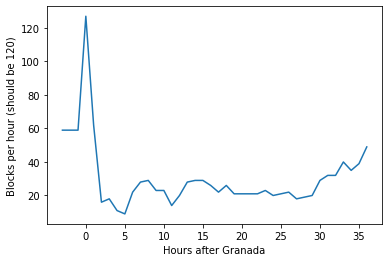

In [55]:
import pandas
import matplotlib.pyplot as plt
from IPython.display import display, HTML


pandas_table = {"hour": [], "num_blocks": []}

for hour, num_blocks in blocks_sorted_by_hour.items():
    pandas_table["hour"].append(hour)
    pandas_table["num_blocks"].append(num_blocks)


    
df = pandas.DataFrame(pandas_table)

#display(HTML(df.to_html()))
plt.plot(df['hour'], df['num_blocks'])
plt.xlabel('Hours after Granada')
plt.ylabel('Blocks per hour (should be 120)')